**참고문헌**  
\[1\] [16-01 트랜스포머(Transformer)](https://wikidocs.net/31379)  
\[2\] [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html#prelims)  

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])



class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    #x      : decoder input
    #memory : output of encoder
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        #print("m.shape : ", m.shape)
        #print("x.shape : ", x.shape)
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    #x.shape = (batch_size, sequence_len)
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)


def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model



![](../images/the-annotated-transformer_14_0.png)



Figure 1: The Transformer - model architecture.

In [3]:
#hyper-parameter
V = 10
N=2
n_src_vocab = V
n_tgt_vocab = V
d_ff = 2048
d_model=512
d_ff=2048
h=8
dropout=0.1

## Full Model

In [4]:
tmp_model = make_model(n_src_vocab, n_tgt_vocab, N)

/tmp/ipykernel_13821/4216612923.py:240: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


## Training
This section describes the training regime for our models.  

We stop for a quick interlude to introduce some of the tools needed to train  
a standard encoder decoder model. First we define a batch object   
that holds the src and target sentences for training, as well as constructing the masks.

## Batches and Masking

In [5]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        #print('tgt_mask.shape', tgt_mask.shape)
        #print('tgt_mask', tgt_mask)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

> Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss  compute function that also handles parameter updates.

## Training Loop

In [6]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        print(f'trg_y.shape: {batch.trg_y.shape}')
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Optimizer 

우리는 Adam 옵티마이저 ([논문 인용](https://arxiv.org/abs/1412.6980))을 사용했으며,    
`β₁ = 0.9, β₂ = 0.98, ε = 10⁻⁹`로 설정했습니다.

**사용예:**    
``` python
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
```

학습률은 다음 수식에 따라 학습 과정 중 변화시켰습니다:

$$learning\_rate = \frac{1}{\sqrt{d_{model}}} * \text{min}(\frac{1}{\sqrt{{step\_num}}}, \frac{step\_num}{warmup\_steps^{1.5}})$$

이 수식은 학습 초기에 warmup_steps 동안 학습률을 선형적으로 증가시키고,   
이후에는 학습 스텝 수의 역제곱근에 비례하여 감소시키는 방식입니다.  
우리는 warmup_steps = 4000으로 설정했습니다.  
> Note: This part is very important. Need to train with this setup of the model.

In [7]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

> Example of the curves of this model for different model sizes and for optimization hyperparameters.

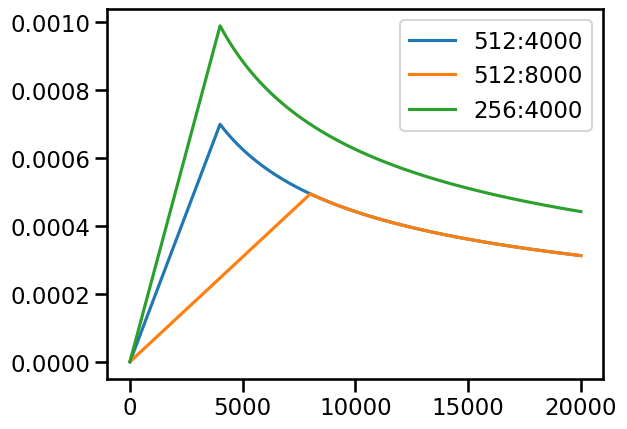

In [8]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## **Regularization**
### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$  
This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution,   
we create a distribution that has confidence of the correct word and the rest of the smoothing mass   
distributed throughout the vocabulary.

In [9]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        #print(f'x.shape:{x.shape}, target.shape:{target.shape}')
        #print(f'target:{target}')
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0 #padding postion = 0
        #print(f"target shape : {true_dist.shape}")
        mask = torch.nonzero(target == self.padding_idx)
        #print("mask: ", mask, mask.dim())
        if mask.shape[0] > 0:
            #print("padding")
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        #print(true_dist)
        return self.criterion(x,true_dist)

> Here we can see an example of how the mass is distributed to the words based on confidence.

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


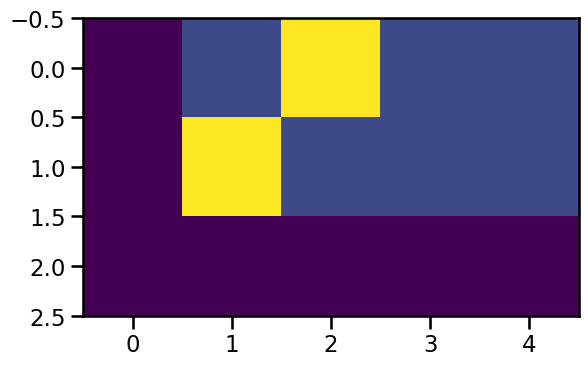

In [10]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

> Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

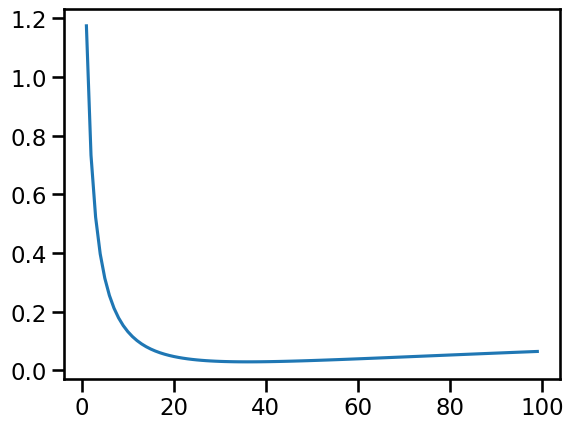

In [11]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 4 * 1
    predict = torch.FloatTensor([[1/d, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

## A First Example
> We can begin by tring out a smple copy-task. Given a random set of input symbols from a small
> Vocabulary, the goal is to generate back those same symbols.

## Synthetic Data

In [12]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## Loss Computation

In [13]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        #print(f"output x shape :{x.shape} norm: {norm}")
        x = self.generator(x)
        #print(f"final x shape :{x.shape}")
        #averaging
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss * norm

## Greedy Decoding

- Greedy decoding은 Transformer 디코더에서 문장을 생성할 때,  
  매 단계에서 가장 확률이 높은 단어만 선택해서 문장을 만드는 방식입니다. 
- The Annotated Transformer에서는 greedy_decode() 함수에서 구현되어 있습니다.
- 예측한 토큰을 디코더에 다시 넣고 반복하며 시퀀스를 생성합니다.
- 빠르지만 탐욕적(greedy) 이기 때문에 항상 최적의 문장을 생성하지는 않습니다
---

** 특징과 한계**  
|항목|	설명|
-----|------|
|장점|	빠르고 간단하며 구현이 쉬움|
|단점|	전역 최적해(global optimum)를 보장하지 않음. 처음 선택이 틀리면 회복 불가|
|비교|	Beam Search보다 성능이 낮지만 속도는 더 빠름|

In [14]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        #print(f'trg_y.shape: {batch.trg_y.shape}')
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [15]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                   SimpleLossCompute(model.generator, criterion, None)))

/tmp/ipykernel_13821/4216612923.py:240: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 3.437773 Tokens per Sec: 1332.515259
Epoch Step: 1 Loss: 1.922881 Tokens per Sec: 2336.129395
tensor(1.9751, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.990017 Tokens per Sec: 1810.822388
Epoch Step: 1 Loss: 1.630767 Tokens per Sec: 2211.138184
tensor(1.6381, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.808302 Tokens per Sec: 1643.620728
Epoch Step: 1 Loss: 1.403281 Tokens per Sec: 2321.144531
tensor(1.4036, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.800757 Tokens per Sec: 1794.727173
Epoch Step: 1 Loss: 1.201273 Tokens per Sec: 2334.220215
tensor(1.2658, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.422200 Tokens per Sec: 1799.078125
Epoch Step: 1 Loss: 1.005549 Tokens per Sec: 2348.992188
tensor(1.0779, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.181157 Tokens per Sec: 1704.204956
Epoch Step: 1 Loss: 0.670202 Tokens per Sec: 2337.373291
tensor(0.6307, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.077570 Tokens per Sec: 1795.051514
Epoch Step: 1 Loss: 0.507


greedy_decode에서 `prob = model.generator(out[:, -1])`의 의미는 ?

**out[:, -1])** 는 출력 token sequece에서 항상 마지막 tocken을 의미함. 

input : [1.2] -> out [1.2]이 나오고  
out[:,-1]는 '2'를 의미함.  
정확하게 `2`의 값을 가진 vocab 차원의 벡터값임. (여기서선 1x11 shape)   

In [20]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        print(ys)
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        print(f"out shape: {out.shape}")
        print(f"out[:-1] shape: {out[:, -1].shape}")
        prob = model.generator(out[:, -1])
        print(f"prob shape: {prob.shape}")
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[1]])
out shape: torch.Size([1, 1, 512])
out[:-1] shape: torch.Size([1, 512])
prob shape: torch.Size([1, 11])
tensor([[1, 2]])
out shape: torch.Size([1, 2, 512])
out[:-1] shape: torch.Size([1, 512])
prob shape: torch.Size([1, 11])
tensor([[1, 2, 3]])
out shape: torch.Size([1, 3, 512])
out[:-1] shape: torch.Size([1, 512])
prob shape: torch.Size([1, 11])
tensor([[1, 2, 3, 5]])
out shape: torch.Size([1, 4, 512])
out[:-1] shape: torch.Size([1, 512])
prob shape: torch.Size([1, 11])
tensor([[1, 2, 3, 5, 4]])
out shape: torch.Size([1, 5, 512])
out[:-1] shape: torch.Size([1, 512])
prob shape: torch.Size([1, 11])
tensor([[1, 2, 3, 5, 4, 6]])
out shape: torch.Size([1, 6, 512])
out[:-1] shape: torch.Size([1, 512])
prob shape: torch.Size([1, 11])
tensor([[1, 2, 3, 5, 4, 6, 5]])
out shape: torch.Size([1, 7, 512])
out[:-1] shape: torch.Size([1, 512])
prob shape: torch.Size([1, 11])
tensor([[1, 2, 3, 5, 4, 6, 5, 8]])
out shape: torch.Size([1, 8, 512])
out[:-1] shape: torch.Size([1, 512])
prob